In [168]:
import pandas as pd
import geopandas as gpd
import os
import osmnx as ox
import rasterio
from rasterio.plot import show as Show
import pylab as plt
data = os.getenv('data')
from rasterstats import point_query

import warnings
warnings.filterwarnings('ignore')

#### 1. Energy facilities layers

In [10]:
transmission = gpd.read_file('https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/145121/ghanafinal.geojson')

In [164]:
solar = gpd.read_file('https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/145127/solar-stations-connected-to-the-grid.geojson')

In [ ]:
generation_facilities = gpd.read_file('http://www.ecowrex.org/geoserver/ecreee/wfs?service=WFS&version=1.1.1&request=GetFeature&typename=ecreee%3Aecreee_v_energy_generators_simple&outputformat=SHAPE-ZIP&srsName=EPSG%3A4326')
generation_facilities = generation_facilities[generation_facilities.country == 'Ghana']
#generation_facilities.to_csv(data+'/energy/generation_facilities.csv')

In [55]:
transmission.head(2)

,voltage_kV,year,status,source,country,length_km,geometry
0,161,2000.0,Existing,ECREEE,Ghana,70,"LINESTRING (0.55247 6.26034, 0.71815 6.22811, ..."
1,161,2000.0,Existing,ECREEE,Ghana,13,"LINESTRING (-0.20408 5.60745, -0.20391 5.60772..."


In [56]:
generation_facilities.head(2)

,nid,country,title,eg_type_id,eg_type,initiative,initiativ0,ree_cat_id,ree_cat,size,current_st,current_ca,lon,lat,geometry
18,2399,Ghana,Bui,98.0,Large Hydro,None,None,"298,197","Hydropower,Large Hydropower (including dam, pu...",Large,Operational,400.0,-2.235203,8.277185,POINT (-2.23520 8.27719)
27,5242,Ghana,The Nzema Project,92.0,PV Solar,None,None,203,Photovoltaic Power Plants Grid-Connected,None,Planned,155.0,-0.197754,5.615980,POINT (-0.19775 5.61598)


In [169]:
solar.head(2)

,SERIAL NO,DATE,REGION,METRO/MUNICIPAL/DISTRICT,INSTITUTION NAME,INSTALLED CAPACITY(kW) GRIDCONNECTED,LOCALITY,LATITUDE,LONGITUDE,X,Y,geometry
0,1,1998,Greater Accra Region,Accra Metropolitan Assembly,Ministry of Energy,50.00,Accra,05.5514N,000.2008W,-0.2008,5.5514,POINT (-0.20080 5.55140)
1,2,8-May,Greater Accra Region,Accra Metropolitan Assembly,Energy Commission,4.25,Accra,05.5975N,000.1829W,-0.1829,5.5975,POINT (-0.18290 5.59750)


#### 2. Boundaries and hazard layers

In [171]:
boundaries = gpd.read_file(data+'/gadm36_GHA_shp/gadm36_GHA_1.shp')[['NAME_1','geometry']]

In [80]:
pluvial10_pth = data + '/energy/Ghana_pluvial_P_1in10.tif'
flood_data = rasterio.open(pluvial10_pth)
flood_data.crs

CRS.from_epsg(4326)

#### 3. Flood overlay example using schools data

In [94]:
ghana_schools = ox.pois.pois_from_place('Ghana',{'amenity':'school'})

/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/osmnx/pois.py:135: UserWarning: The `pois` module has been deprecated and will be removed in a future release. Use the `geometries` module's `geometries_from_place` function instead.
  warnings.warn(msg)


In [95]:
ghana_schools.shape

/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2911, 101)

In [99]:
ghana_schools.head(2)

,unique_id,osmid,element_type,amenity,name,geometry,nodes,operator,opening_hours,min_age,...,building:material,roof:material,grades,office,is_in,landuse,comment,loc_name,place,roof:shape
0,node/2145887582,2145887582,node,school,Nsein Senior High School,POINT (-2.21922 4.87712),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/4538423352,4538423352,node,school,Essiama Senior High Technical School,POINT (-2.34812 4.93584),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
# ghana_schools.to_csv(data+'/energy/ghana_schools.csv')

In [108]:
ghana_schools = ghana_schools[ghana_schools.element_type == 'node'][['name','geometry']]

/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


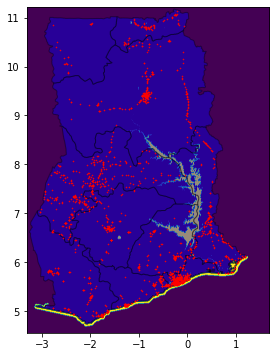

In [109]:
f,ax = plt.subplots(figsize=[8,6])
Show(flood_data,ax=ax)
boundaries.plot(edgecolor='k',facecolor='blue',alpha=0.4,ax=ax)
ghana_schools.plot(ax=ax,color='r',markersize=0.3);

In [110]:
ghana_schools['10yr_depth'] = point_query(ghana_schools, pluvial10_pth)

/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [121]:
ghana_schools = gpd.sjoin(ghana_schools,boundaries)

/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
ghana_schools['flood_status'] = ghana_schools['10yr_depth'] > 0
flooded_schools = ghana_schools[ghana_schools.flood_status]

/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [141]:
ghana_schools.NAME_1.value_counts().sort_index()

Ashanti          121
Brong Ahafo      329
Central          148
Eastern          159
Greater Accra    529
Northern         293
Upper East        76
Upper West        22
Volta            198
Western          175
Name: NAME_1, dtype: int64

In [153]:
number_flooded = flooded_schools.NAME_1.value_counts().sort_index().values
percent_flooded = flooded_schools.NAME_1.value_counts().sort_index().values / ghana_schools.NAME_1.value_counts().sort_index().values * 100
state_names = ghana_schools.NAME_1.value_counts().sort_index().index
flooding_summary = pd.DataFrame(index = state_names, data={'number_flooded': number_flooded, 'percent_flooded': percent_flooded})
flooding_summary.percent_flooded = flooding_summary.percent_flooded.round(1)
flooding_summary

/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,number_flooded,percent_flooded
Ashanti,2,1.7
Brong Ahafo,18,5.5
Central,14,9.5
Eastern,19,11.9
Greater Accra,12,2.3
Northern,17,5.8
Upper East,4,5.3
Upper West,1,4.5
Volta,19,9.6
Western,26,14.9


In [174]:
ghana_schools.columns

Index(['name', 'geometry', '10yr_depth', 'index_right', 'NAME_1',
       'flood_status'],
      dtype='object')

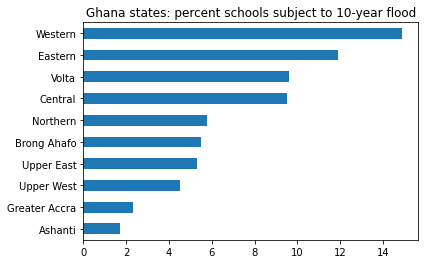

In [162]:
flooding_summary.percent_flooded.sort_values(ascending=True).plot(kind='barh')
plt.title('Ghana states: percent schools subject to 10-year flood');

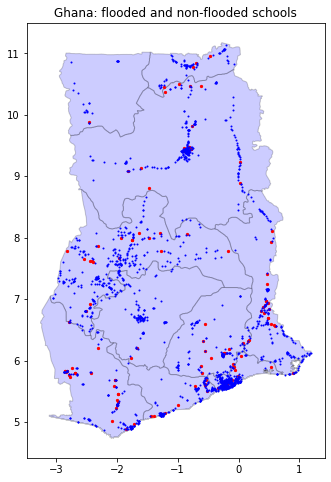

In [182]:
f,ax = plt.subplots(figsize=[12,8])
boundaries.plot(edgecolor='k',facecolor='blue',alpha=0.2,ax=ax)
ghana_schools[ghana_schools.flood_status].plot(ax=ax,color='r',markersize=5)
ghana_schools[~ghana_schools.flood_status].plot(ax=ax,color='b',markersize=1)
plt.title('Ghana: flooded and non-flooded schools');


#### 4. Flood overlay with power generation facilities

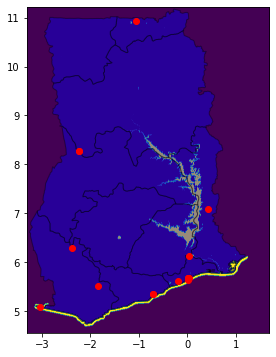

In [77]:
f,ax = plt.subplots(figsize=[8,6])
Show(flood_data,ax=ax)
boundaries.plot(edgecolor='k',facecolor='blue',alpha=0.4,ax=ax)
generation_facilities.plot(ax=ax,color='r');

In [82]:
generation_facilities['10yr_depth'] = point_query(generation_facilities, pluvial10_pth)

In [84]:
generation_facilities.columns

Index(['nid', 'country', 'title', 'eg_type_id', 'eg_type', 'initiative',
       'initiativ0', 'ree_cat_id', 'ree_cat', 'size', 'current_st',
       'current_ca', 'lon', 'lat', 'geometry', '10yr_depth'],
      dtype='object')

<BarContainer object of 16 artists>

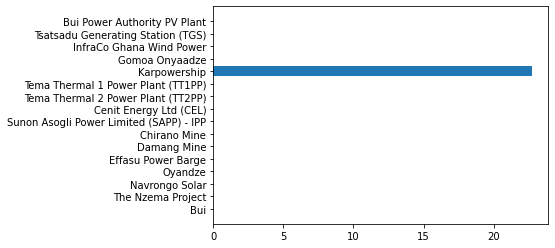

In [92]:
plt.barh(generation_facilities.title, generation_facilities['10yr_depth'])

#### 5. Linear features
* various strategies: eg. rasterize and count flooded pixels

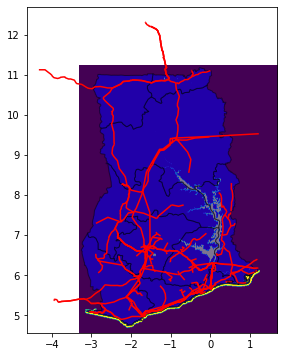

In [172]:
f,ax = plt.subplots(figsize=[6,6])
Show(flood_data,ax=ax)
boundaries.plot(edgecolor='k',facecolor='b',alpha=0.5,ax=ax)
transmission.plot(ax=ax,color='r');